In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, Flatten
from keras.layers import MaxPooling2D, Activation, Dropout
%matplotlib inline

# Data Preparation & Preprocessing

In [2]:
#crop the part that contains only the brain of the image,cropping technique to find the extreme top, 
#bottom, left and right points of the brain.
def crop_brain_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

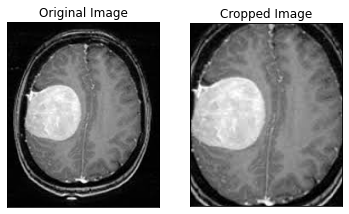

In [3]:
ex_img = cv2.imread('brain_tumor_dataset/train/yes/Y1.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

# Load up the data

In [4]:
def load_data(dir_list, image_size):
    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '\\' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [5]:
augmented_path = 'brain_tumor_dataset/train/'
augmented_yes = augmented_path + 'yes' 
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 973
X shape is: (973, 240, 240, 3)
y shape is: (973, 1)


In [6]:
def plot_sample_images(X, y, n=50): 
    for label in [0,1]:
        images = X[np.argwhere(y == label)]
        n_images = images[:n]        
        columns_n = 10
        rows_n = int(n/ columns_n)
        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

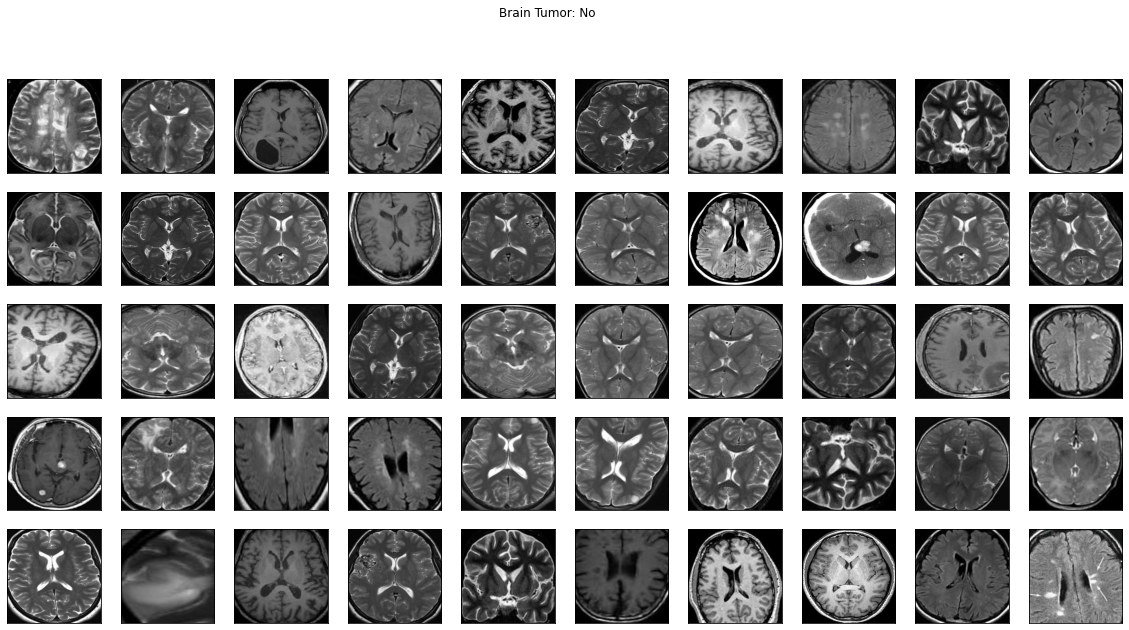

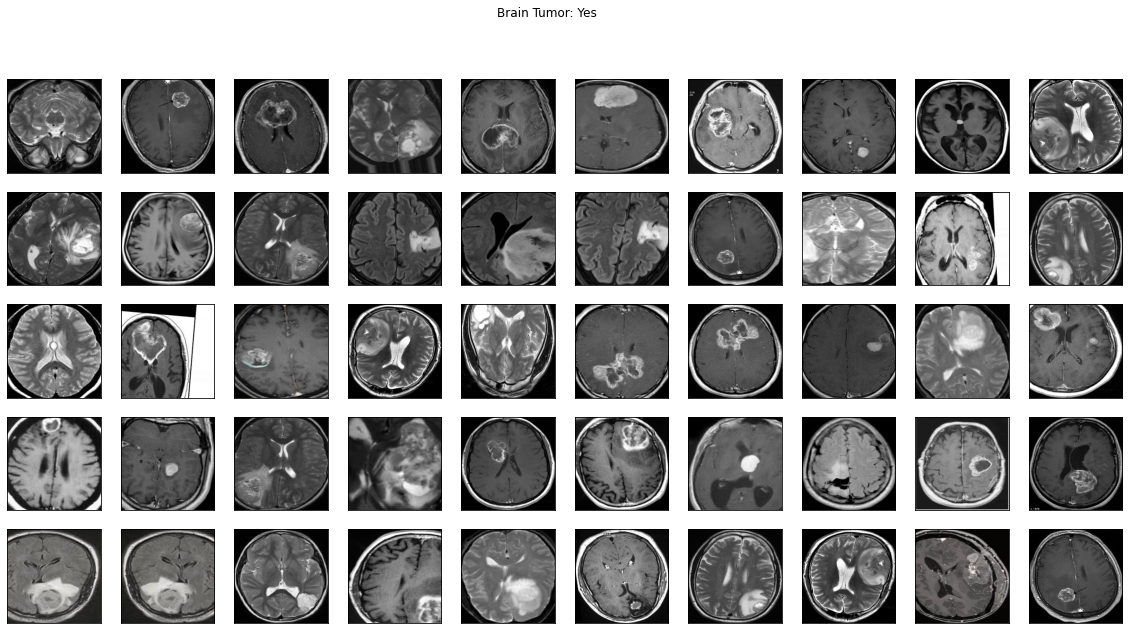

In [7]:
plot_sample_images(X, y)

In [8]:
def split_data(X, y, test_size=0.2):
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [9]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [10]:
def compute_f1_score(y_true, prob):
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

In [11]:
def build_model(input_shape):
    X_input = Input(input_shape) 

    X = ZeroPadding2D((2, 2))(X_input)

    X = Conv2D(32, (7, 7), strides = (2, 2), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) 

    X = MaxPooling2D((4, 4), name='max_pool0')(X) 

    X = MaxPooling2D((4, 4), name='max_pool1')(X) 

    X = Flatten()(X) 

    X = Dense(1, activation='sigmoid', name='fc')(X)

    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

In [12]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
model = build_model(IMG_SHAPE)
model.summary()

Model: "BrainDetectionModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 244, 244, 3)      0         
 2D)                                                             
                                                                 
 conv0 (Conv2D)              (None, 119, 119, 32)      4736      
                                                                 
 bn0 (BatchNormalization)    (None, 119, 119, 32)      128       
                                                                 
 activation (Activation)     (None, 119, 119, 32)      0         
                                                                 
 max_pool0 (MaxPooling2D)    (None, 29, 29, 32)        0         
                                               

In [13]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
model.fit(x=X_train, y=y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
22/22 [==============================] - 10s 407ms/step - loss: 0.8148 - accuracy: 0.5727 - val_loss: 0.6598 - val_accuracy: 0.5822
Epoch 2/20
22/22 [==============================] - 8s 381ms/step - loss: 0.5854 - accuracy: 0.7093 - val_loss: 0.6513 - val_accuracy: 0.6096
Epoch 3/20
22/22 [==============================] - 8s 352ms/step - loss: 0.5050 - accuracy: 0.7651 - val_loss: 0.6620 - val_accuracy: 0.6301
Epoch 4/20
22/22 [==============================] - 8s 356ms/step - loss: 0.4631 - accuracy: 0.7959 - val_loss: 0.6167 - val_accuracy: 0.6301
Epoch 5/20
22/22 [==============================] - 10s 449ms/step - loss: 0.4343 - accuracy: 0.8062 - val_loss: 0.6099 - val_accuracy: 0.6507
Epoch 6/20
22/22 [==============================] - 7s 340ms/step - loss: 0.4125 - accuracy: 0.8223 - val_loss: 0.6396 - val_accuracy: 0.5890
Epoch 7/20
22/22 [==============================] - 9s 401ms/step - loss: 0.3812 - accuracy: 0.8561 - val_loss: 0.5972 - val_accuracy: 0.7123
Epoc

In [15]:
model.save('brain_tumor_detector.h5')

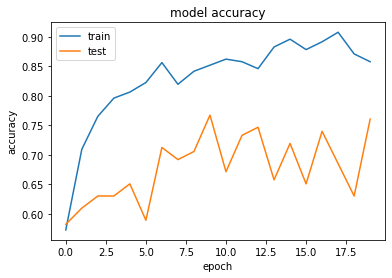

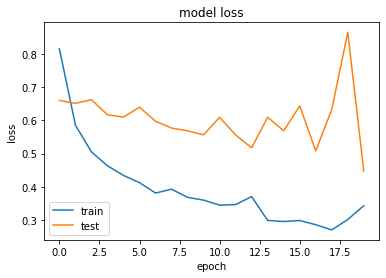

In [16]:
history = model.history
    # print(history.history.keys())
    # summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()
    # summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()  

In [17]:
loss, acc = model.evaluate(x=X_test, y=y_test)

5/5 [==============================] - 0s 85ms/step - loss: 0.4606 - accuracy: 0.7603


In [18]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.4605554938316345
Test Accuracy = 0.7602739930152893


In [19]:
y_test_prob =model.predict(X_test)

In [20]:
print(y_test_prob)

[[0.81201565]
 [0.18684277]
 [0.7181047 ]
 [0.85193074]
 [0.8645814 ]
 [0.77570164]
 [0.8844743 ]
 [0.3633187 ]
 [0.46694237]
 [0.83960915]
 [0.7773072 ]
 [0.5497626 ]
 [0.9161115 ]
 [0.6400347 ]
 [0.974687  ]
 [0.95825106]
 [0.90880316]
 [0.952065  ]
 [0.5254968 ]
 [0.91959023]
 [0.8388811 ]
 [0.949224  ]
 [0.03642812]
 [0.02534124]
 [0.90207237]
 [0.33379704]
 [0.21353999]
 [0.15365833]
 [0.3357577 ]
 [0.86301553]
 [0.10644987]
 [0.5721586 ]
 [0.8690013 ]
 [0.5811747 ]
 [0.6484302 ]
 [0.16205734]
 [0.63811326]
 [0.7014046 ]
 [0.81497884]
 [0.76212156]
 [0.5857063 ]
 [0.10996747]
 [0.7254236 ]
 [0.87600315]
 [0.07549015]
 [0.16911814]
 [0.7419153 ]
 [0.88207257]
 [0.3777341 ]
 [0.83234787]
 [0.39827764]
 [0.24599826]
 [0.7169609 ]
 [0.5254829 ]
 [0.8453535 ]
 [0.63070655]
 [0.35592633]
 [0.03960043]
 [0.73013246]
 [0.7502363 ]
 [0.83432806]
 [0.08340737]
 [0.7420211 ]
 [0.18317184]
 [0.9182236 ]
 [0.98945594]
 [0.73059   ]
 [0.42375445]
 [0.2507585 ]
 [0.8560263 ]
 [0.10479486]
 [0.80

In [21]:
f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")

F1 score: 0.8186528497409327


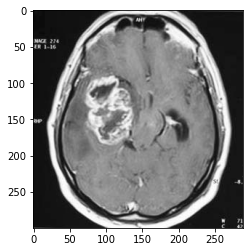

Tumor


In [22]:
#Sample prediction to check the model performance on new image
image = 'brain_tumor_dataset/train/yes/Y14.jpg'
img2 = cv2.imread(image)
plt.imshow(img2.squeeze())
plt.show()
img = cv2.resize(img2,(240,240))
img = np.reshape(img, (1, 240, 240, 3))
classes = (model.predict(img)).astype("float32")
if(classes>=0.5):
    print("Tumor")
else:
    print("Normal")

In [23]:
from tensorflow.keras.models import load_model
import cv2 as cv
import imutils

model = load_model('brain_tumor_detector.h5')


def predictTumor(image):
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    gray = cv.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv.threshold(gray, 45, 255, cv.THRESH_BINARY)[1]
    thresh = cv.erode(thresh, None, iterations=2)
    thresh = cv.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv.findContours(thresh.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv.contourArea)

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    image = cv.resize(new_image, dsize=(240, 240), interpolation=cv.INTER_CUBIC)
    image = image / 255.

    image = image.reshape((1, 240, 240, 3))

    res = model.predict(image)

    return res

In [24]:
import tkinter
from PIL import Image
from tkinter import filedialog
import cv2 as cv
class DisplayTumor:
    curImg = 0
    Img = 0

    def readImage(self, img):
        self.Img = np.array(img)
        self.curImg = np.array(img)
        gray = cv.cvtColor(np.array(img), cv.COLOR_BGR2GRAY)
        self.ret, self.thresh = cv.threshold(gray, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)

    def getImage(self):
        return self.curImg

    def removeNoise(self):
        self.kernel = np.ones((3, 3), np.uint8)
        opening = cv.morphologyEx(self.thresh, cv.MORPH_OPEN, self.kernel, iterations=2)
        self.curImg = opening

    def displayTumor(self):
        # sure background area
        sure_bg = cv.dilate(self.curImg, self.kernel, iterations=3)

        # Finding sure foreground area
        dist_transform = cv.distanceTransform(self.curImg, cv.DIST_L2, 5)
        ret, sure_fg = cv.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

        # Find unknown region
        sure_fg = np.uint8(sure_fg)
        unknown = cv.subtract(sure_bg, sure_fg)

        # Marker labelling
        ret, markers = cv.connectedComponents(sure_fg)

        # Add one to all labels so that sure background is not 0, but 1
        markers = markers + 1

        # Now mark the region of unknown with zero
        markers[unknown == 255] = 0
        markers = cv.watershed(self.Img, markers)
        self.Img[markers == -1] = [255, 0, 0]

        tumorImage = cv.cvtColor(self.Img, cv.COLOR_HSV2BGR)
        self.curImg = tumorImage

In [25]:
import tkinter
from PIL import ImageTk
from PIL import Image

class Frames:
    xAxis = 0
    yAxis = 0
    MainWindow = 0
    MainObj = 0
    winFrame = object()
    btnClose = object()
    btnView = object()
    image = object()
    method = object()
    callingObj = object()
    labelImg = 0

    def __init__(self, mainObj, MainWin, wWidth, wHeight, function, Object, xAxis=10, yAxis=10):
        self.xAxis = xAxis
        self.yAxis = yAxis
        self.MainWindow = MainWin
        self.MainObj = mainObj
        self.MainWindow.title("Brain Tumor Detection")
        if (self.callingObj != 0):
            self.callingObj = Object

        if (function != 0):
            self.method = function

        global winFrame
        self.winFrame = tkinter.Frame(self.MainWindow, width=wWidth, height=wHeight)
        self.winFrame['borderwidth'] = 5
        self.winFrame['relief'] = 'ridge'
        self.winFrame.place(x=xAxis, y=yAxis)

        self.btnClose = tkinter.Button(self.winFrame, text="Close", width=8,
                                      command=lambda: self.quitProgram(self.MainWindow))
        self.btnClose.place(x=1020, y=600)
        self.btnView = tkinter.Button(self.winFrame, text="View", width=8, command=lambda: self.NextWindow(self.method))
        self.btnView.place(x=900, y=600)


    def setCallObject(self, obj):
        self.callingObj = obj


    def setMethod(self, function):
        self.method = function


    def quitProgram(self, window):
        global MainWindow
        self.MainWindow.destroy()


    def getFrames(self):
        global winFrame
        return self.winFrame


    def unhide(self):
        self.winFrame.place(x=self.xAxis, y=self.yAxis)


    def hide(self):
        self.winFrame.place_forget()


    def NextWindow(self, methodToExecute):
        listWF = list(self.MainObj.listOfWinFrame)

        if (self.method == 0 or self.callingObj == 0):
            print("Calling Method or the Object from which Method is called is 0")
            return

        if (self.method != 1):
            methodToExecute()
        if (self.callingObj == self.MainObj.DT):
            img = self.MainObj.DT.getImage()
        else:
            print("Error: No specified object for getImage() function")

        jpgImg = Image.fromarray(img)
        current = 0

        for i in range(len(listWF)):
            listWF[i].hide()
            if (listWF[i] == self):
                current = i

        if (current == len(listWF) - 1):
            listWF[current].unhide()
            listWF[current].readImage(jpgImg)
            listWF[current].displayImage()
            self.btnView['state'] = 'disable'
        else:
            listWF[current + 1].unhide()
            listWF[current + 1].readImage(jpgImg)
            listWF[current + 1].displayImage()

        print("Step " + str(current) + " Extraction complete!")


    def removeComponent(self):
        self.btnClose.destroy()
        self.btnView.destroy()


    def readImage(self, img):
        self.image = img


    def displayImage(self):
        imgTk = self.image.resize((250, 250), Image.ANTIALIAS)
        imgTk = ImageTk.PhotoImage(image=imgTk)
        self.image = imgTk
        self.labelImg = tkinter.Label(self.winFrame, image=self.image)
        self.labelImg.place(x=700, y=150)

In [26]:
import tkinter
from PIL import Image
from tkinter import filedialog
import cv2 as cv


class Gui:
    MainWindow = 0
    listOfWinFrame = list()
    FirstFrame = object()
    val = 0
    fileName = 0
    DT = object()

    wHeight = 700
    wWidth = 1180

    def __init__(self):
        global MainWindow
        MainWindow = tkinter.Tk()
        MainWindow.geometry('1200x720')
        MainWindow.resizable(width=False, height=False)

        self.DT = DisplayTumor()

        self.fileName = tkinter.StringVar()

        self.FirstFrame = Frames(self, MainWindow, self.wWidth, self.wHeight, 0, 0)
        self.FirstFrame.btnView['state'] = 'disable'

        self.listOfWinFrame.append(self.FirstFrame)

        WindowLabel = tkinter.Label(self.FirstFrame.getFrames(), text="Brain Tumor Detection", height=1, width=40)
        WindowLabel.place(x=320, y=30)
        WindowLabel.configure(background="White", font=("Comic Sans MS", 16, "bold"))

        self.val = tkinter.IntVar()
        RB1 = tkinter.Radiobutton(self.FirstFrame.getFrames(), text="Detect Tumor", variable=self.val,
                                  value=1, command=self.check)
        RB1.place(x=250, y=200)
        RB2 = tkinter.Radiobutton(self.FirstFrame.getFrames(), text="View Tumor Region",
                                  variable=self.val, value=2, command=self.check)
        RB2.place(x=250, y=250)

        browseBtn = tkinter.Button(self.FirstFrame.getFrames(), text="Browse", width=8, command=self.browseWindow)
        browseBtn.place(x=800, y=550)

        MainWindow.mainloop()

    def getListOfWinFrame(self):
        return self.listOfWinFrame

    def browseWindow(self):
        global mriImage
        FILEOPENOPTIONS = dict(defaultextension='*.*',
                               filetypes=[('jpg', '*.jpg'), ('png', '*.png'), ('jpeg', '*.jpeg'), ('All Files', '*.*')])
        self.fileName = filedialog.askopenfilename(**FILEOPENOPTIONS)
        image = Image.open(self.fileName)
        imageName = str(self.fileName)
        mriImage = cv.imread(imageName, 1)
        self.listOfWinFrame[0].readImage(image)
        self.listOfWinFrame[0].displayImage()
        self.DT.readImage(image)

    def check(self):
        global mriImage
        #print(mriImage)
        if (self.val.get() == 1):
            self.listOfWinFrame = 0
            self.listOfWinFrame = list()
            self.listOfWinFrame.append(self.FirstFrame)

            self.listOfWinFrame[0].setCallObject(self.DT)

            res = predictTumor(image)
            
            if res > 0.5:
                resLabel = tkinter.Label(self.FirstFrame.getFrames(), text="Tumor Detected", height=1, width=20)
                resLabel.configure(background="White", font=("Comic Sans MS", 16, "bold"), fg="red")
            else:
                resLabel = tkinter.Label(self.FirstFrame.getFrames(), text="No Tumor", height=1, width=20)
                resLabel.configure(background="White", font=("Comic Sans MS", 16, "bold"), fg="green")

            resLabel.place(x=700, y=450)

        elif (self.val.get() == 2):
            self.listOfWinFrame = 0
            self.listOfWinFrame = list()
            self.listOfWinFrame.append(self.FirstFrame)

            self.listOfWinFrame[0].setCallObject(self.DT)
            self.listOfWinFrame[0].setMethod(self.DT.removeNoise)
            secFrame = Frames(self, MainWindow, self.wWidth, self.wHeight, self.DT.displayTumor, self.DT)

            self.listOfWinFrame.append(secFrame)


            for i in range(len(self.listOfWinFrame)):
                if (i != 0):
                    self.listOfWinFrame[i].hide()
            self.listOfWinFrame[0].unhide()

            if (len(self.listOfWinFrame) > 1):
                self.listOfWinFrame[0].btnView['state'] = 'active'

        else:
            print("Not Working")

mainObj = Gui()

Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\Atharva P Deshpande\Documents\Anaconda\lib\tkinter\__init__.py", line 1892, in __call__
    return self.func(*args)
  File "<ipython-input-26-c59ba0ff3b01>", line 75, in check
    res = predictTumor(image)
  File "<ipython-input-23-e0f33a6625e4>", line 9, in predictTumor
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
TypeError: Expected cv::UMat for argument 'src'


Step 0 Extraction complete!
Step 1 Extraction complete!
